In [1]:
# authors Max
import threading
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import random
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os
sys.path.append('taming-transformers')
from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False
from torch_optimizer import DiffGrad, AdamP, RAdam
from CLIP import clip
import kornia.augmentation as K
import imageio
from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True
from subprocess import Popen, PIPE
import re
import pickle

In [2]:
patches = {0: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#95cbd1', 'resblock_7': '#83c0cf', 'resblock_9': '#bce6da', 'resblock_11': '#83c0cf', 'embedding_layer': '#612937'}, 1: {'conv1': '#fed3ac', 'resblock_1': '#9ed1d3', 'resblock_3': '#bce6da', 'resblock_5': '#80bece', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#494da1', 'embedding_layer': '#572732'}, 2: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#a0d2d3', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#38365f', 'embedding_layer': '#95cbd1'}, 3: {'conv1': '#3d3a6c', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#80bece', 'resblock_7': '#83c0cf', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#5e2836'}, 4: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#4953b0', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#b33241', 'embedding_layer': '#fed3ac'}, 5: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#86c2cf', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#e36133'}, 6: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#4855b3', 'resblock_7': '#68b0cd', 'resblock_9': '#bce6da', 'resblock_11': '#3f69c9', 'embedding_layer': '#fcc699'}, 7: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#8fc7d0', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#5c2835', 'embedding_layer': '#1e1e1e'}, 8: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#3b70cd', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#2d1e21', 'embedding_layer': '#fed3ac'}, 9: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#3f8fce', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#434282', 'embedding_layer': '#d34936'}, 10: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#7dbcce', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#b33241'}, 11: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#7abbce', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#2a1e20'}, 12: {'conv1': '#572732', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#95cbd1', 'resblock_7': '#a6d6d5', 'resblock_9': '#bce6da', 'resblock_11': '#3b70cd', 'embedding_layer': '#fed3ac'}, 13: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#9bcfd2', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#241d1e'}, 14: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#4067c7', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#bce6da', 'embedding_layer': '#692a3a'}, 15: {'conv1': '#bce6da', 'resblock_1': '#bce6da', 'resblock_3': '#bce6da', 'resblock_5': '#86c2cf', 'resblock_7': '#bce6da', 'resblock_9': '#bce6da', 'resblock_11': '#80bece', 'embedding_layer': '#962e44'}}

In [3]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [10]:
def combine_patches(patches, true_image="", image_size=(256,256), ncols=4, cav_layer='embedding_layer'):
    patch_filename = f'{cav_layer}_patched.png'

    # Build patched image
    ppp = image_size[0]//ncols # pixels per patch
    im_patches = np.zeros((ncols**2,ppp,ppp,4))
    p = 0
    for i in range(len(im_patches)):
        for pix_i in range(ppp):
            for pix_j in range(ppp):
                im_patches[i,pix_i,pix_j] = np.concatenate((hex_to_rgb(patches[p][cav_layer]),[255]))
        p+=1
    
    # Plot patched image without padding
    fig, axes = plt.subplots(nrows=4,ncols=4, figsize=(5, 5))
    for i, ax in enumerate(axes.ravel()):
        ax.axis('off')
        ax.axes.get_yaxis().set_visible(False)
        ax.imshow(im_patches[i].astype(int))
        ax.margins(x=0,y=0)  
    plt.tight_layout(pad=0) # or do 0.1 if we want a tiny amount of padding?
    plt.savefig(f'{cav_layer}_patched.png', pad_inches=0)
    plt.close()

    # If comparing to true image, plot with true image
    # return filenames
    if true_image == "":
        return(patch_filename)
    else:
        patch_and_real_filename = f'{cav_layer}_patched_and_real.png'
        fig, axes = plt.subplots(ncols=2, figsize=(10,5))
        images = [Image.open(true_image), Image.open(patch_filename)]
        for i, ax in enumerate(axes.ravel()):
            ax.axis('off')
            ax.axes.get_yaxis().set_visible(False)
            ax.imshow(images[i])
        plt.tight_layout(pad=0.3)
        plt.savefig(patch_and_real_filename, pad_inches=0)
        plt.close()
        return(patch_and_real_filename)

UnboundLocalError: local variable 'patch_filename' referenced before assignment

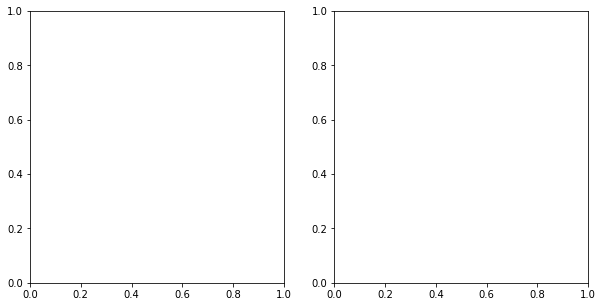

In [11]:
# filename = combine_patches(patches) # if just want patched image
filename = combine_patches(patches, true_image='output.png') # if want side by side true_image

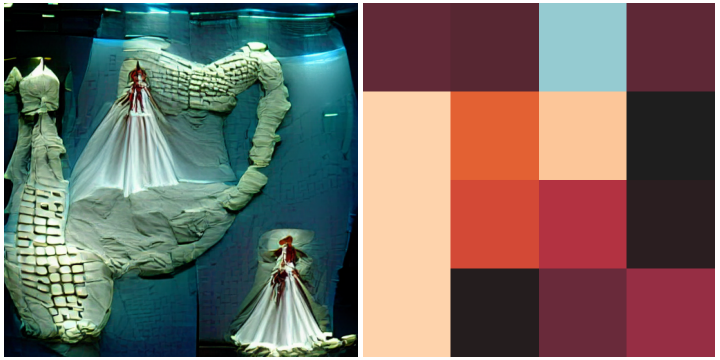

In [8]:
Image.open(filename)